In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

Loading in data, Sept 7th to Dec 7th, respresenting the fall semester for NYC public schools:

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
# weeks: sept 7th to december 7th, 2019    
week_nums = [190907, 190914, 190921, 190928, 191005, 191012, 191019,
            191026, 191102, 191109, 191116, 191123, 191130, 191207]
df_read = get_data(week_nums)

Making the DataFrame we're working with a copy of the read-in data, so if an incorrect manipulation is made, can be reset easily without having to read in data again:

In [3]:
df = df_read 
df.shape

(2882165, 11)

Creating a DATETIME column, and replacing DATE and TIME columns' entries (currently, 'object' types) with 'datetime objects':

In [4]:
df["DATETIME"] = pd.to_datetime(df["DATE"] + " " + df["TIME"], format="%m/%d/%Y %H:%M:%S")

In [5]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y")
df["TIME"] = pd.to_datetime(df["TIME"])

Cleaning up column name for EXIT column, which had many trailing spaces: 

In [6]:
df.rename(columns={'EXITS                                                               ':"EXITS"}, inplace=True)

Finding actual entries and exits for each row (typically, 4-hour time period) by finding difference between each entry/exit 'total count' value and the value that precedes it, for each turnstile. We are filtering by C/A, UNIT, and SCP, since those 3 descriptors together define a single turnstile:

In [7]:
df.reset_index(inplace=True)

In [8]:
real_entries = df.groupby(["C/A", "UNIT", "SCP"]).agg({"ENTRIES": "diff"})

In [9]:
real_exits = df.groupby(["C/A", "UNIT", "SCP"]).agg({"EXITS": "diff"})

> The above used pandas "diff" as aggregating function. From pandas documention for "diff": "Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is the element in the same column of the previous row)." This is exactly what we wanted to do. We broke it up into each individual unit first, becuase we only want it to subtract from entry/exit data for its own turnstile. therefore, first values for each turnstile, with nothing to subtract from (no preceding value), return NaN.

Adding new columns for actual entries and exits to the DataFrame:

In [10]:
df["REAL_ENTRIES"] = real_entries["ENTRIES"]
df["REAL_EXITS"] = real_exits["EXITS"]

Exploring the new real traffic data: there are many values which appear that are erroneous -- some which are extremely large and not possibly representative of real entries or exits in a 4-hour period, and some which are negative. Both types are likely caused by turnstile errors or resets, and need to be removed. Examples of the most extemely erroneous data included below: 

In [11]:
df["REAL_ENTRIES"].sort_values(ascending=False).head(10)

2440547   2037956058.0
2027192   1754729527.0
1402753   1704548686.0
2027234   1554189845.0
1157898    730710276.0
1157894    730710263.0
1157896    730710262.0
1157892    730710255.0
1157890    730710208.0
73163      718560745.0
Name: REAL_ENTRIES, dtype: float64

In [12]:
df["REAL_EXITS"].sort_values(ascending=False).head(10)

73163     1886405893.0
1402753   1019395842.0
2440547    902456873.0
366070     568618937.0
1408555    300790885.0
1815960    267405278.0
2027192    150359755.0
2027234    133731198.0
1744346    100844994.0
1616439    100304985.0
Name: REAL_EXITS, dtype: float64

In [13]:
df["REAL_ENTRIES"].sort_values().head(10)

1068802   -2025847485.0
792556    -2013355772.0
1204647   -1186521378.0
1068768   -1121336461.0
386825     -991539584.0
1157895    -730710262.0
1157897    -730710254.0
1157893    -730710240.0
1157899    -730710220.0
1157891    -730710088.0
Name: REAL_ENTRIES, dtype: float64

In [14]:
df["REAL_EXITS"].sort_values().head(10)

1068768   -1907466468.0
1204647    -885740374.0
792556     -839005509.0
1397682    -721823991.0
436975     -701914974.0
1068802    -622024878.0
386825     -504187450.0
2024480     -50412910.0
742744      -50330882.0
207269      -20876713.0
Name: REAL_EXITS, dtype: float64

First, removing the negative and NaN values from the data, knowing that this will remove the entire row which contains the error. 

In [15]:
df = df.loc[df["REAL_ENTRIES"] >= 0]

In [16]:
df = df.loc[df["REAL_EXITS"] >= 0]

In [17]:
df.shape

(2843278, 15)

So far, this has removed about 80,000 data points, which constitues only 2.5% of the total data. We have decided it is appropriate to remove this amount of data, since it not only comprises a very small percentage, but also because including the data would be for more skewing to our results since the values are so incorrect than would simply removing them. 

Now, we want to remove the very large values -- practically, we want to eliminate entry/exit data which is abnormal for its specific turnstile/station. Some values (2000, e.g.) may be very normal for certain stations (like Times Square), but may be highly irregular for another station. If we define a cutoff threshhold above some general number for all of the data, that would allow 2000 to stay; but if a turnstile's average 4-hour ridership is only 15 people, a value of 2000 should in fact be removed and indicates an error (or, at best, a one-time anomolous event which we don't need to base our average values on anyway). It is for this reason that an arbitrary cut off value should not be chosen for the entire dataset, but rather averages for each station should inform that stations individual cutoff value for an unrealistic/error entry to be removed. 

To do this first requires finding average 4-hour (single-row) ridership values for each station. We are grouping by both STATION and LINENAME because we discovered that multiple stations have the same name, but are in fact separate (though nearby) and service different lines. Therefore it is the combination of STATION and LINENAME which comprise a single station. We are also using median over mean as our determination of 'average' ridership, because median values will be less skewed by the presence of extremely large error numbers. 

In [23]:
station_averages = df.groupby(["STATION", "LINENAME"])[["REAL_ENTRIES", "REAL_EXITS"]].median()

In [24]:
station_averages.reset_index(inplace=True)

In [25]:
station_averages.rename(columns={"REAL_ENTRIES":"AVERAGE_ENTRIES"}, inplace=True)
station_averages.rename(columns={"REAL_EXITS":"AVERAGE_EXITS"}, inplace=True)


Adding columns for average values into main DataFrame: 

In [21]:
df = pd.merge(left=df, right=station_averages, left_on=["STATION", "LINENAME"], right_on=["STATION", "LINENAME"])

Now, using average values to filter out any single 4-hour entry with ridership greater than 100 times the average for that station. This will remove error values and also even if it removes a real value, if there was a surge of 2 orders of magnitude above normal, it is probably a standalone event that doesn't help inform our data.

In [31]:
df = df.loc[df["REAL_ENTRIES"] < 100*df["AVERAGE_ENTRIES"]]

In [32]:
df = df.loc[df["REAL_EXITS"] < 100*df["AVERAGE_EXITS"]]

In [33]:
df.shape

(2762803, 17)

After the removal of these high positive values, we have lost only about 4% of the data total. Much of those lost were NaN values which weren't data to begin with. 

Now in observing the highest entry values, they are of normal and expected magnitude, with only 3 exceptions at the top: 

In [34]:
df["REAL_ENTRIES"].sort_values(ascending=False).head(10)

367310    14832.0
367267    10233.0
1256340    5968.0
1652732    5204.0
833191     5137.0
335157     4830.0
833233     4426.0
1257520    4399.0
2221917    4308.0
1652721    4270.0
Name: REAL_ENTRIES, dtype: float64

In [35]:
df["REAL_EXITS"].sort_values(ascending=False).head(10)

1999665   15980.0
367310     7693.0
367267     7636.0
833275     6624.0
43561      5598.0
1945522    5203.0
334899     5184.0
778290     5097.0
778339     5064.0
774996     5005.0
Name: REAL_EXITS, dtype: float64

Now that the data is cleaned, we can combine entries and exits into a single value representative of the total traffic at that station in a given time frame:

In [39]:
df["TRAFFIC"] = df["REAL_ENTRIES"] + df["REAL_EXITS"]

Now we can group the data in various ways analyze it: 

In [42]:
daily_traffic = df.groupby(["STATION", "LINENAME", "DATE"])[["TRAFFIC"]].sum()

In [47]:
daily_traffic.reset_index(inplace=True)

In [44]:
total_station_traffic = df.groupby(["STATION", "LINENAME"])[["TRAFFIC"]].sum()

In [46]:
total_station_traffic.reset_index(inplace=True)

Finding busiest stations by total traffic to check the accuracy of our data analysis:

In [54]:
total_station_traffic.sort_values(by="TRAFFIC", ascending=False).head(20)

,STATION,LINENAME,TRAFFIC
310,GRD CNTRL-42 ST,4567S,22706169.0
88,34 ST-HERALD SQ,BDFMNQRW,19936316.0
92,34 ST-PENN STA,ACE,13653526.0
101,42 ST-PORT AUTH,ACENQRS1237W,12353636.0
28,14 ST-UNION SQ,LNQR456W,11583395.0
441,TIMES SQ-42 ST,1237ACENQRSW,10921827.0
105,47-50 STS ROCK,BDFM,10440520.0
300,FULTON ST,2345ACJZ,10056623.0
124,59 ST COLUMBUS,ABCD1,9842010.0
287,FLUSHING-MAIN,7,9091166.0


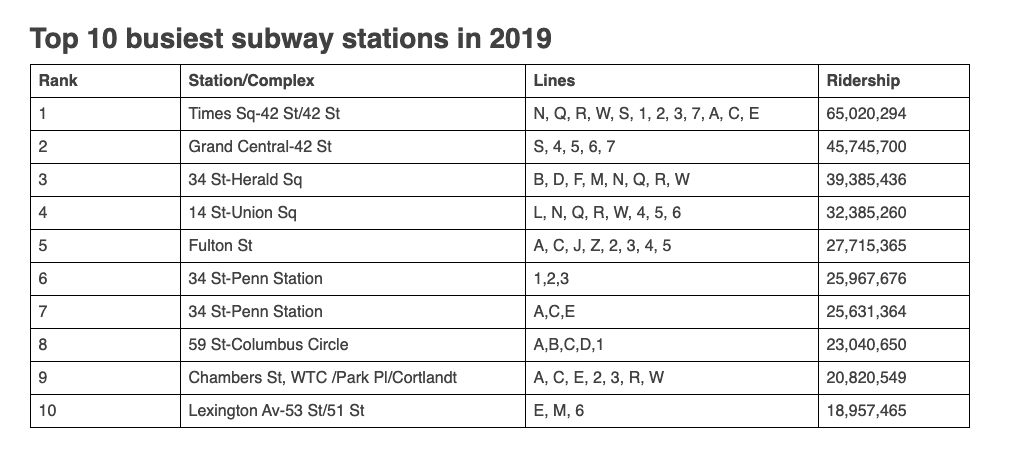

Verifying the top busiest stations against actual busiest stations in 2019 (above) to verify accuracy of our filtered data, our data analysis has proved correct. The busiest 10 are all within our busiest top 20, and this is only for three months's worth of data which may have discrepencies from the yearly total. Excellent! Now we can move forward with further analysis after confirming the accuracy of how we've handled the data thus far. 

Now, to focus on what the client needs. Sunny Futures STEM is looking for the ideal locations to hold science outreach events, that will have the most exposure to kids in underprivelaged areas, in order to get them excited about STEM and benefit their future. 

Our plan is to have them set up near subway stations located closest to underachieving schools, such that kids on their commute home from those schools will get to see the demonstrations. For this reason, we must find which schools have the most need, which stations are the closest to those schools, and which of those stations have the highest ridership, such that the STEM outreach event can be placed strategically to get the most traffic. 

First of all, students will only be commuting on weekdays, so we can filter out weekend data from our station traffic totals: 

In [55]:
daily_traffic["DAY"] = daily_traffic["DATE"].dt.day_name()
daily_traffic["DAY_ALIAS"] = daily_traffic["DATE"].dt.dayofweek

In [56]:
daily_weekday_traffic = daily_traffic[daily_traffic["DAY_ALIAS"] < 5]

Graphing total traffic over the 3 months per day, to see which days would be most advantageous to set up the demos, demonstrated that really any day except for Monday would be a fine choice. Days besides Friday would be advantageous because that way kids are still in their school week and more likely to stop and engage with our science fair demos, rather than running off to their weekend. 

In [63]:
traffic_by_day = daily_weekday_traffic.groupby(["DAY"])[["TRAFFIC"]].sum()
traffic_by_day.reset_index(inplace=True)

<BarContainer object of 5 artists>

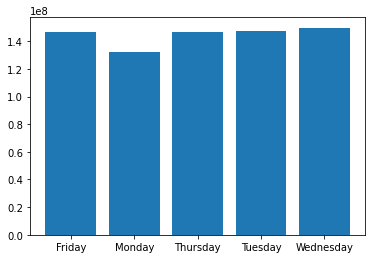

In [64]:
plt.bar(traffic_by_day["DAY"], traffic_by_day["TRAFFIC"])

Now, finding total station traffic as above, but summing over weekday traffic only:

In [65]:
total_station_traffic_weekdays = daily_weekday_traffic.groupby(["STATION", "LINENAME"])[["TRAFFIC"]].sum()
total_station_traffic_weekdays.reset_index(inplace=True)

Next, we need to identify which schools in NYC are underachieving, whose students would be in the most need of some inspiration towards a STEM future. To do this, we read in an excel file from the NYC Department of Education's InfoHub, which contained ratings for every elementary, middle and k-8 school across a wide range of metrics. 

The metrics we determined as most relevent indicators of need and under-performance were "Student Achievement Rating" and "Economic Need Index". Here we filter by those metrics, and display the School Data Frame with the 20 most underachieving schools by those standards: 

In [66]:
pd.set_option("display.max_columns", None)

column_names = ['1', '2', '3', 'DBN', 'School Name', 'School Type', 'Enrollment', 'Rigorous Instruction Rating', 'Collaborative Teachers Rating', 'Supportive Environment Rating', 'Effective School Leadership Rating', 'Strong Family-Community Ties Rating', 'Trust Rating', 'Student Achievement Rating', 'Rigorous Instruction-Percent Positive', 'Collaborative Teachers-Percent Positive', 'Supportive Environment-Percent Positive', 'Effective School Leadership-Percent Positive', 'Strong Family-Community Ties-Percent Positive', 'Trust-Percent Positive', 'Quality Review-Interesting/Challenging Curriculum?', 'Quality Review-Effectiveness of Teaching and Learning', 'Quality Review- How Well School Assesses Student Learning', 'Quality Review-High Expectations Communicated Clearly?', 'Quality Review-How Well Do Teachers Work Together?', 'Quality Review-How Safe & Inclusive is School?', 'Quality Review- How Well School Allocates/Manages Resources', 'Quality Review-How Well School Identify/Track/Meet Goals', 'Quality Review- How Thoughtful is School\'s Approach to Teacher Development/Evaluation', 'Quality Review- How Well School Decisions Evaluated/Adjusted?', 'Quality Review- Dates of Review', 'Average Incoming ELA Proficiency (Based on 5th Grade)', 'Average Incoming Math Proficiency (Based on 5th Grade)', 'Percent English Language Learners', 'Percent Students w/ Disabilities', 'Percent Self-Contained', 'Economic Need Index', 'Percent in Temp Housing', 'Percent HRA Eligible', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 'Percent White', 'Years of Principal Experience @ School', 'Percent of Teachers w/ 3 or More Years Experience', 'Student Attendance Rate', 'Percent of Students Chronically Absent', 'Teacher Attendance Rate']
elementary_data = pd.read_excel(r'https://infohub.nyced.org/docs/default-source/default-document-library/201819_ems_sqr_results.xlsx', names=column_names)
elementary_data.drop(elementary_data.index[:4], inplace=True)
elementary_data.drop(columns=['1', '2', '3'], inplace=True)
elementary_data.dropna(how='any', inplace=True)
not_meeting_target_achievement = elementary_data[elementary_data['Student Achievement Rating'] == 'Not Meeting Target']
at_risk_schools = (not_meeting_target_achievement[not_meeting_target_achievement['Economic Need Index'] > 0.7]).sort_values(by='Economic Need Index', ascending=False)
at_risk_schools.head(20)

,DBN,School Name,School Type,Enrollment,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Effective School Leadership Rating,Strong Family-Community Ties Rating,Trust Rating,Student Achievement Rating,Rigorous Instruction-Percent Positive,Collaborative Teachers-Percent Positive,Supportive Environment-Percent Positive,Effective School Leadership-Percent Positive,Strong Family-Community Ties-Percent Positive,Trust-Percent Positive,Quality Review-Interesting/Challenging Curriculum?,Quality Review-Effectiveness of Teaching and Learning,Quality Review- How Well School Assesses Student Learning,Quality Review-High Expectations Communicated Clearly?,Quality Review-How Well Do Teachers Work Together?,Quality Review-How Safe & Inclusive is School?,Quality Review- How Well School Allocates/Manages Resources,Quality Review-How Well School Identify/Track/Meet Goals,Quality Review- How Thoughtful is School's Approach to Teacher Development/Evaluation,Quality Review- How Well School Decisions Evaluated/Adjusted?,Quality Review- Dates of Review,Average Incoming ELA Proficiency (Based on 5th Grade),Average Incoming Math Proficiency (Based on 5th Grade),Percent English Language Learners,Percent Students w/ Disabilities,Percent Self-Contained,Economic Need Index,Percent in Temp Housing,Percent HRA Eligible,Percent Asian,Percent Black,Percent Hispanic,Percent White,Years of Principal Experience @ School,Percent of Teachers w/ 3 or More Years Experience,Student Attendance Rate,Percent of Students Chronically Absent,Teacher Attendance Rate
296,09X350,New Directions Secondary School,Middle,81,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Not Meeting Target,0.7,0.7,0.6,0.8,0.8,0.8,Proficient,Developing,Developing,Proficient,Proficient,Proficient,Proficient,Developing,Proficient,Proficient,April 2018,2.0,2.0,0.3,0.3,0.1,1.0,0.3,1.0,0.0,0.3,0.6,0.0,6.1,0.6,0.6,0.8,1.0
210,07X224,P.S./I.S. 224,Middle,328,Approaching Target,Not Meeting Target,Approaching Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,0.6,0.4,0.6,0.6,0.9,0.7,Proficient,Developing,Proficient,Proficient,Developing,Proficient,Proficient,Proficient,Proficient,Proficient,March 2017,2.1,2.4,0.2,0.3,0.1,1.0,0.3,0.9,0.0,0.3,0.7,0.0,0.1,0.7,0.9,0.4,0.9
145,05M194,P.S. 194 Countee Cullen,Elementary,183,Meeting Target,Meeting Target,Meeting Target,Meeting Target,Meeting Target,Approaching Target,Not Meeting Target,0.7,0.6,0.5,0.7,0.9,0.8,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Well Developed,Proficient,May 2018,.,.,0.2,0.3,0.1,1.0,0.4,0.9,0.0,0.6,0.3,0.0,0.9,0.7,0.9,0.3,0.9
7,01M034,P.S. 034 Franklin D. Roosevelt,K-8,288,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,0.7,0.7,0.6,0.7,0.9,0.8,Developing,Developing,Developing,Proficient,Proficient,Developing,Proficient,Proficient,Proficient,Developing,October 2017,.,.,0.1,0.4,0.0,0.9,0.3,0.9,0.0,0.3,0.6,0.0,2.7,0.5,0.9,0.5,1.0
641,19K663,School of the Future Brooklyn,Middle,193,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,0.7,0.6,0.6,0.8,0.9,0.8,Developing,Developing,Developing,Developing,Developing,Proficient,Proficient,Developing,Proficient,Developing,May 2017,2.1,2.0,0.1,0.3,0.0,0.9,0.3,0.9,0.0,0.7,0.3,0.0,1.1,0.5,0.9,0.4,1.0
114,04M057,James Weldon Johnson,K-8,762,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Not Meeting Target,0.6,0.6,0.6,0.5,0.9,0.7,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,February 2018,.,.,0.1,0.3,0.1,0.9,0.3,0.8,0.0,0.3,0.7,0.0,1.3,0.8,0.9,0.4,1.0
757,23K323,P.S./I.S. 323,K-8,548,Meeting Target,Meeting Target,Approaching Target,Meeting Target,Meet